In [25]:
import torch
import einops
import matplotlib.pyplot as plt
from taker import Model

m: Model = Model()
sample_text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua."

def get_acts(m, text=sample_text):
    # Tell model to collect activations for the MLP pre-output
    m.hooks.enable_collect_hooks(["mlp_pre_out"])
    # Run model and get activations
    m.get_outputs_embeds(text)
    acts = m.collect_recent_mlp_pre_out()
    return acts.detach().cpu().float()

def plot_acts(acts, label, layer, alpha=0.3, bins = 100):
    # Reshape activations to be a 2D array with one row per layer
    # Plot histogram of activations for the given layer
    acts = einops.rearrange(acts, "1 layer token dim -> layer (token dim)")
    plt.hist(acts[layer], bins=bins, label=label, alpha=alpha, density=True)


Loaded model 'nickypro/tinyllama-15m' with bfp16:
- Added 96 hooks across 6 layers


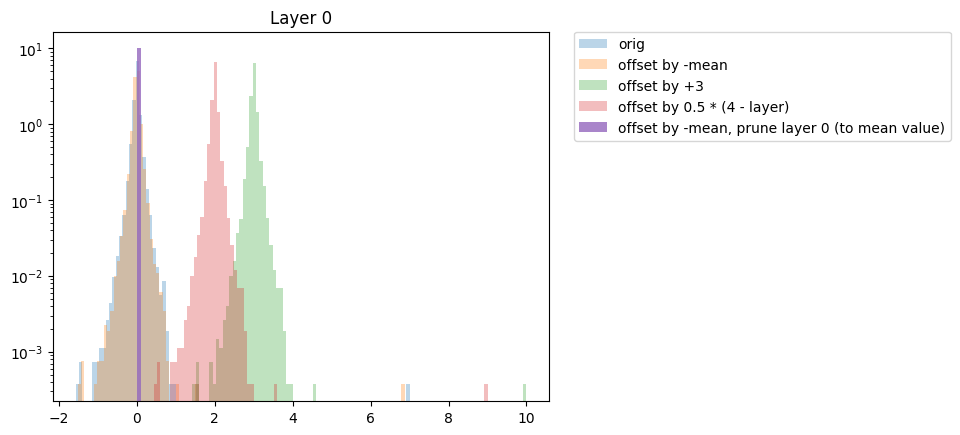

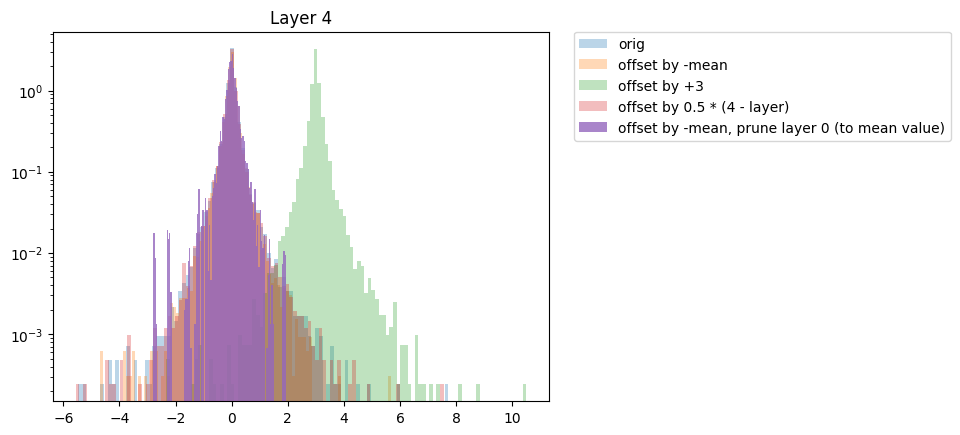

In [33]:
for layer_index in [0, 4]:
    # Get original activations
    m.hooks.reset() # resets all hooks, including offsets to zero
    acts = get_acts(m) # get activations on ipsum text
    plot_acts(acts, "orig", layer_index)

    # OFFSET BY: -MEAN
    # Note: that the offsets are "visual" only
    # - The model computes neuron activation X
    # - We look at the neuron activation X + offset = X - X_mean
    # - The activations are then returned to the model as:
    #     (X - X_mean) - offset = X - X_mean + X_mean = X
    # The final output is the same as if we had not applied the offset (up to numerical precision)
    # Note: This doesn't seem to have a huge visual effect.
    # It seems to show values are slightly "closer to zero" on average maybe?

    # Get the mean activations for each neuron
    mean_acts = einops.reduce(acts, "batch layer token dim -> layer dim", "mean")
    # Offset by the negative of the mean activations ( centered on the mean )
    offsets = - mean_acts
    m.hooks["mlp_pre_out"].set_offsets(offsets)
    acts = get_acts(m)
    # plot histogram of activations for the given layer
    plot_acts(acts, "offset by -mean", layer_index)


    # OFFSET BY: CONSTANT
    # This offset just shifts the activations by a constant value
    # Again, the final output is the same as if we had not applied the offset (up to numerical precision)
    offsets = 3.0 * torch.ones([m.cfg.n_layers, m.cfg.d_mlp])
    m.hooks["mlp_pre_out"].set_offsets(offsets)
    acts = get_acts(m)
    plot_acts(acts, "offset by +3", layer_index)


    # OFFSET EACH LAYER BY: 0.1 * (4 - layer_index)
    # This should show that:
    # - the activations in layer 0 are offset by 0.5 * 4 = 2.0,
    # - the activations in layer 4 are offset by 0.0, and
    #   that the actual activations are the same as if we had not applied the
    #   offset, even though we offset previous layer activations
    offsets = torch.ones([m.cfg.n_layers, m.cfg.d_mlp])
    for i in range(m.cfg.n_layers):
        offsets[i] *= 0.5 * (4 - i)
    m.hooks["mlp_pre_out"].set_offsets(offsets)
    acts = get_acts(m)
    plot_acts(acts, f"offset by 0.5 * (4 - layer)", layer_index)

    # OFFSET BY: MEAN BUT PRUNE LAYER 0 NEURONS
    # We prune within the offset basis. That is:
    # - The model computes neuron activation X
    # - We look at the neuron activation X + offset = X - X_mean
    # - We mask the values, doing Y = (X - X_mean -> 0)
    # - The activations are then returned to the model as:
    #     Y - offset = Y + X_mean = X_mean
    mean_acts = einops.reduce(acts, "batch layer token dim -> layer dim", "mean")
    offsets = - mean_acts
    m.hooks["mlp_pre_out"].set_offsets(offsets)
    m.hooks["mlp_pre_out"].delete_neurons(torch.ones(m.cfg.d_mlp), layer=0)
    acts = get_acts(m)
    label = "offset by -mean, prune layer 0 (to mean value)"
    if layer_index == 0:
        # we zoom in on the layer 0 neurons since they are all set to 0.0 within the offset basis
        # note that they are actually non-zero in the original activations
        # (they are a fixed value = -mean)
        plot_acts(acts, label, layer_index, alpha=0.8, bins=10)
    else:
        plot_acts(acts, label, layer_index, alpha=0.8, bins=100)

    # make plots
    plt.title(f"Layer {layer_index}")
    plt.semilogy()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
